This first project aims to follow this tutorial: https://www.youtube.com/watch?v=o-zM8onpQZY


following this i will out my own spin on it and expand the concept (with my own writeup for the site)


after the first creation i will try and replicate it using yahoo finance for australian stocks


make one function for the entire parsing process




get data from yahoo finance, try getting the sentiment for different currencies, then make a backtester using yahoo finance data. maybe try with stocks first and switch to forex

maybe try and write out a ton of basic strategies

In [4]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

# for todays date
from datetime import date as dt

The link:
* https://finviz.com/quote.ashx?t=VIRC&p=d

note how the ticker is part of the link

In [5]:
# url ready to add the ticker to
finviz_url = "https://finviz.com/quote.ashx?t="
# tickers to investigate
tickers = ['AMZN', 'AMD', 'META']

In [99]:
# get data for each ticker

news_tables = {}
# id for the news table
news_table_id ='news-table'
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    # now we have a http response object that can be parsed by beautiful soup
    html = BeautifulSoup(response, 'html')

    # we will now parse the html by the id for the table the news data is in 
    news_table = html.find(id=news_table_id)
    # add to dict
    news_tables[ticker] = news_table

In [102]:
# now find the headlines from the table (make this a function later)

parsed_data = []
for ticker, news_table in news_tables.items():
    data = news_tables[ticker]
    rows = data.findAll('tr')

    # get all the titles and their timestamp
    for index, row in enumerate(rows):
        title = row.a.text
        date_data = row.td.text.strip().split(' ')

        if len(date_data) == 2: # if there is a date and time
            date = date_data[0]
            time = date_data[1]

        else: # if there is just a time
            time = date_data[0]
            # use the previous date as the date

        # get the date for today
        if date=='Today':
            date = dt.today().strftime('%b-%d-%y')

        parsed_data.append([ticker, date, time, title])
print(parsed_data[200])


['META', 'Sep-25-23', '05:45PM', 'Meta Platforms (META) Outpaces Stock Market Gains: What You Should Know']


ntlk vader will be used for sentiment analysis

In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
vader = SentimentIntensityAnalyzer()

In [104]:
# lets make this a dataframe
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df.head()

,ticker,date,time,title
0,AMZN,Sep-26-23,01:05AM,China's e-commerce discount race to the bottom...
1,AMZN,Sep-26-23,01:00AM,FOCUS-China's e-commerce discount race to the ...
2,AMZN,Sep-25-23,07:28PM,What is Anthropic? The buzzy AI startup just g...
3,AMZN,Sep-25-23,06:49PM,Jeff Bezoss space company Blue Origin picks Am...
4,AMZN,Sep-25-23,06:34PM,12 Best Low Cost ETFs


In [105]:

#print(vader.polarity_scores('apple is an terrible company'))

# make the new row
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f) # apply the lambda function

print(df.head())

  ticker       date     time  \
0   AMZN  Sep-26-23  01:05AM   
1   AMZN  Sep-26-23  01:00AM   
2   AMZN  Sep-25-23  07:28PM   
3   AMZN  Sep-25-23  06:49PM   
4   AMZN  Sep-25-23  06:34PM   

                                               title  compound  
0  China's e-commerce discount race to the bottom...   -0.2960  
1  FOCUS-China's e-commerce discount race to the ...   -0.2960  
2  What is Anthropic? The buzzy AI startup just g...    0.1779  
3  Jeff Bezoss space company Blue Origin picks Am...    0.1779  
4                              12 Best Low Cost ETFs    0.4767  


In [106]:
# convert to datetime object
df['date'] = pd.to_datetime(df.date).dt.date

/var/folders/f5/9kn8mtyn7p1cdn40mw2mhtn80000gn/T/ipykernel_12310/3844680211.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df.date).dt.date


In [107]:
plt.figure(figsize=(10,8))

mean_df = df.groupby(['ticker', 'date']).agg(avg = ('compound','mean')) # get the mean for each day
mean_df = mean_df.unstack() # turn the date into the top
mean_df = mean_df.xs('avg', axis='columns').transpose()
mean_df

ticker,AMD,AMZN,META
date,,,
2023-08-29,0.000000,NaN,NaN
2023-08-30,0.212500,NaN,NaN
2023-08-31,0.108775,NaN,NaN
2023-09-01,0.425700,NaN,NaN
2023-09-02,0.190900,NaN,NaN
2023-09-03,0.220200,NaN,NaN
2023-09-04,0.241060,NaN,NaN
2023-09-05,0.360400,NaN,NaN
2023-09-06,-0.067433,NaN,NaN


<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='date'>

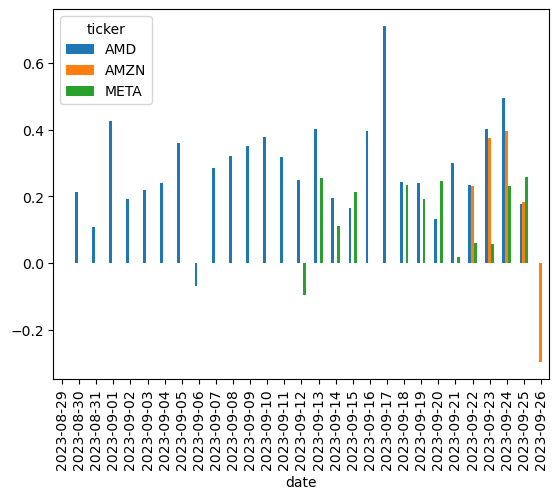

In [108]:
mean_df.plot(kind='bar')

In [68]:
df

,ticker,date,time,title,compound
0,AMZN,2023-09-26,01:05AM,China's e-commerce discount race to the bottom...,-0.2960
1,AMZN,2023-09-26,01:00AM,FOCUS-China's e-commerce discount race to the ...,-0.2960
2,AMZN,2023-09-25,07:28PM,What is Anthropic? The buzzy AI startup just g...,0.1779
3,AMZN,2023-09-25,06:49PM,Jeff Bezoss space company Blue Origin picks Am...,0.1779
4,AMZN,2023-09-25,06:34PM,12 Best Low Cost ETFs,0.4767
...,...,...,...,...,...
295,META,2023-09-22,08:22AM,"Is Amazon Stock a Buy Ahead of Its ""Prime Big ...",0.1779
296,META,2023-09-22,07:28AM,Amazon Is Latest to Add Advertising to Streami...,0.1779
297,META,2023-09-22,06:50AM,Amazon to Put Ads in Prime Video Shows and Movies,0.1779
298,META,2023-09-22,06:30AM,3 Good Reasons to Buy Your Pet Supplies From C...,0.4404


In [78]:
mean_df = df.groupby(['ticker', 'date']).agg(avg =('compound','mean'))

mean_df.head()

avg
ticker date                
AMD    2023-09-22  0.230668
       2023-09-23  0.376311
       2023-09-24  0.395323
       2023-09-25  0.183692
       2023-09-26 -0.296000

In [89]:
df[df['ticker'] =='AMZN']['compound'], df[df['ticker'] =='META']['compound']

(0    -0.2960
 1    -0.2960
 2     0.1779
 3     0.1779
 4     0.4767
        ...  
 95    0.1779
 96    0.1779
 97    0.1779
 98    0.4404
 99    0.4767
 Name: compound, Length: 100, dtype: float64,
 200   -0.2960
 201   -0.2960
 202    0.1779
 203    0.1779
 204    0.4767
         ...  
 295    0.1779
 296    0.1779
 297    0.1779
 298    0.4404
 299    0.4767
 Name: compound, Length: 100, dtype: float64)

In [98]:
df[df['ticker'] =='AMZN']['title'][1], df[df['ticker'] =='META']['title'][201]

("FOCUS-China's e-commerce discount race to the bottom puts incumbents under pressure",
 "FOCUS-China's e-commerce discount race to the bottom puts incumbents under pressure")

In [1]:
from news_scraping import news_scraper

In [4]:
tickers1 = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
sum_data = news_scraper(tickers1, avg_type='sum').finvis()
mean_data = news_scraper(tickers1, avg_type='mean').finvis()

/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Stock news sentiment/news_scraping.py:44: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 44 of the file /Users/jasperchong/PycharmProjects/Statistical Arbitrage/Stock news sentiment/news_scraping.py. To get rid of this warning, pass the additional argument 'features="html5lib"' to the BeautifulSoup constructor.

  html = BeautifulSoup(response, 'html')
/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Stock news sentiment/news_scraping.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

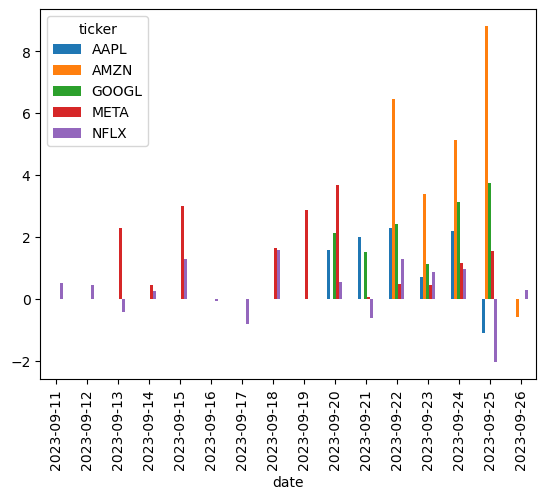

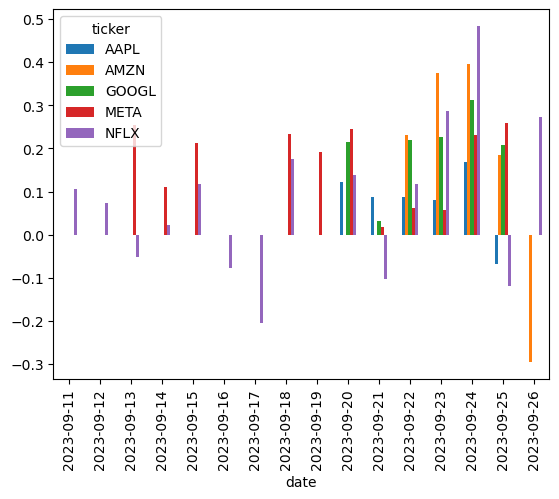

In [6]:
sum_data.plot(kind='bar'), mean_data.plot(kind='bar')

In [8]:
mean_data['AAPL']

date
2023-09-11         NaN
2023-09-12         NaN
2023-09-13         NaN
2023-09-14         NaN
2023-09-15         NaN
2023-09-16         NaN
2023-09-17         NaN
2023-09-18         NaN
2023-09-19         NaN
2023-09-20    0.122708
2023-09-21    0.087030
2023-09-22    0.088215
2023-09-23    0.079922
2023-09-24    0.168785
2023-09-25   -0.069150
2023-09-26         NaN
Name: AAPL, dtype: float64